In [1]:
%%capture
!pip install networkx numpy pandas statsmodels

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import statsmodels.api as sm
from typing import Set

# Potential Outcomes

By Alessio Zanga and Fabio Stella

## Abstract

This notebook illustrates a step-by-step example on estimating the average causal effect (ACE) of sodium on blood pressure following [Luque-Fernandez et al. (2018)](https://academic.oup.com/ije/article/48/2/640/5248195). The main focus of this work is to highlight the differences between a naive estimate and the adjusted estimate.

## Introduction

Exceeding the recommendations for 24-h dietary **sodium** (SOD) intake is associated with increased levels of **systolic blood pressure** (SBP). Furthermore, with advancing **age**, the adaptive mechanism responsible for maintaining the composition and volume of the extracellular fluid is compromised. Age is a common cause of both high systolic blood pressure and impaired sodium homeostasis, acting as a confounder. However, high levels of 24-h excretion of **urinary protein** (PRO) are caused by sustained high SBP and increased dietary SOD, acting as a collider.

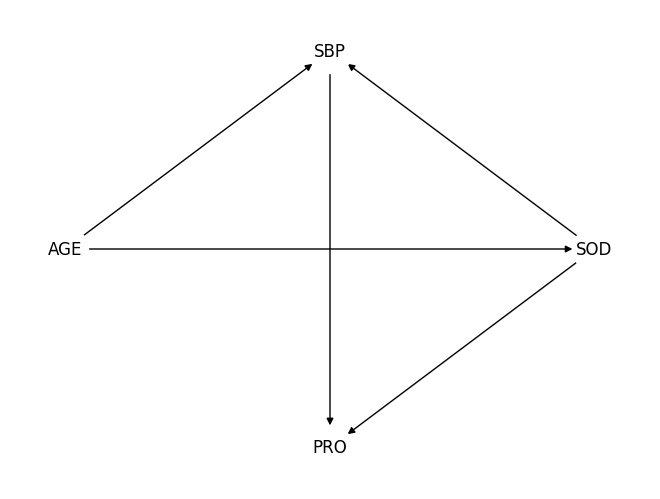

In [2]:
G = nx.DiGraph()
G.add_edges_from([("SOD", "SBP"), ("AGE", "SOD"), ("AGE", "SBP"), ("SOD", "PRO"), ("SBP", "PRO")])
nx.draw_circular(G, node_size=1000, node_color="white", with_labels=True)

Assuming **linear relationships** between the variables and **gaussian noise**, a data generation process that is consistent with the represented causal graph follows directly.

In [3]:
def sample_data(size: int = int(1e6), seed: int = 31):
    # Set random generator seed for results reproducibility
    np.random.seed(seed)
    # Sample age with mean 65 and std 5
    age = np.random.normal(65, 5, size)
    # Sample sodium with additive noise
    sod = 0.056 * age + np.random.normal(0, 1, size)
    # Binarize sodium following cutoff
    sod = (sod > 3.5).astype(int)
    # Sample systolic blood pressure
    sbp = 1.05 * sod + 2 * age + np.random.normal(0, 1, size)
    # Sample urinary protein
    pro = 0.4 * sod + 0.3 * sbp + np.random.normal(0, 1, size)
    # Create a dataframe from sampled variables
    return pd.DataFrame({"AGE": age, "SOD": sod, "SBP": sbp, "PRO": pro})

Here, the true ACE is given by the coefficient 1.05 that assign SBP a value given SOD.

In [4]:
data = sample_data()
data.describe()

,AGE,SOD,SBP,PRO
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,65.001134,0.552995,130.583161,39.396720
std,4.993518,0.497184,10.161539,3.263477
min,40.964418,0.000000,82.816817,24.421988
25%,61.627703,0.000000,123.720103,37.190745
50%,65.009236,1.000000,130.597297,39.402344
75%,68.372794,1.000000,137.445514,41.602773
max,87.717317,1.000000,176.708462,54.573313


## Methods

Assuming consistency, positivity, and unconfoundedness, the average causal effect (ACE) is defined:

$\tau = \mathbb{E}[Y(1) - Y(0)] = \mathbb{E}_\textbf{Z}[\mathbb{E}[Y(1) - Y(0)|\textbf{Z}]] = \mathbb{E}_\textbf{Z}[\mathbb{E}[Y|X=1,\textbf{Z}] - \mathbb{E}[Y|X=0,\textbf{Z}]]$

Replacing expectations with empirical mean:

$\hat{\tau} = \frac{1}{n} \sum_{i=1}^{n} [\mathbb{E}[Y|X=1,\textbf{Z}=\mathbf{z_{i}}] - \mathbb{E}[Y|X=0,\textbf{Z}=\mathbf{z_{i}}]]$

It is possible to choose any machine learning model for $\mathbb{E}[Y|X,\textbf{Z}]$, such as a linear regression model, which works out nicely since blood pressure is generated as a linear combination of other variables.

In [5]:
def ACE(data: pd.DataFrame, X: str, Y: str, Z: Set[str]):
    # Define the regresion model formula
    formula = f"{Y} ~ {X}"
    if len(Z) != 0: formula += "+" + "+".join(Z)
    # Fit Ordinary Least Square regression model
    estimator = sm.OLS.from_formula(formula, data).fit()
    # Compute potential outcomes by fixing X
    Y1 = estimator.predict(data.assign(**{X: 1}))
    Y0 = estimator.predict(data.assign(**{X: 0}))
    # Compute average causal effect
    return np.mean(Y1 - Y0)

## Results

The true ACE is:

In [6]:
ace = 1.05

The estimated ACE adjusting for AGE and PRO is:

In [7]:
t = ACE(data, X = "SOD", Y = "SBP", Z = ["AGE", "PRO"])
f"Estimated ACE: {t:.3}, Relative Error: {(np.abs((t-ace)/ace*100)):.4}%"

'Estimated ACE: 0.856, Relative Error: 18.46%'

While the naive estimated ACE without adjustment is:

In [8]:
t = ACE(data, X = "SOD", Y = "SBP", Z = [])
f"Estimated ACE: {t:.3}, Relative Error: {(np.abs((t-ace)/ace*100)):.4}%"

'Estimated ACE: 5.37, Relative Error: 411.5%'

Since PRO is a collider we shouldn't condition on it. 
The estimated ACE adjusting for AGE is:

In [9]:
t = ACE(data, X = "SOD", Y = "SBP", Z = ["AGE"])
f"Estimated ACE: {t:.3}, Relative Error: {(np.abs((t-ace)/ace*100)):.4}%"

'Estimated ACE: 1.05, Relative Error: 0.2269%'

## Conclusions

Applying a naive regression model without adjustment leads to an estimated ACE which is four times off. A regression model with a valid adjustment set reduce the relative error to only 18%.